# Assignment 6

CS4172 Machine Learning Lab

Name: Abhiroop Mukherjee

Enrolment Number: 510519109

## Task 1

Download and extract the flower image dataset from https://www.kaggle.com/alxmamaev/flowers-recognition.

## Task 2

The dataset contains five classes of flower images of variable sizenamely chamomile, tulip, rose, sunflower, dandelion. Resize all images to 80*80 pixels and convert all color images to grey images.

## Task 3

Randomly shuffle all images to create training, test set with ratio of 90:10, respectively. (Reduce the training size by 1/ 5 if computation resources are limited).

In [1]:
import tensorflow as tf
import random 


import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" #ignore CUDA messages

DATASET_DIRECTORY_PATH = '../ML_DRIVE/Assign_6/flowers/'
seed = random.randint(0,100)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory= DATASET_DIRECTORY_PATH,
    labels="inferred",
    label_mode="categorical", #output of model will be softmax categorical
    color_mode="grayscale",
    batch_size=32,
    image_size=(80,80),
    shuffle=True,
    seed=seed, #same seed for both dataset so that no overlap happens
    validation_split=0.1, #90:10 split
    subset='training',
    crop_to_aspect_ratio=False,
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory= DATASET_DIRECTORY_PATH,
    labels="inferred",
    label_mode="categorical", #output of model will be softmax categorical
    color_mode="grayscale",
    batch_size=32,
    image_size=(80,80),
    shuffle=True,
    seed=seed,
    validation_split=0.1, #90:10 split
    subset='validation',
    crop_to_aspect_ratio=False,
)

Found 4317 files belonging to 5 classes.
Using 3886 files for training.
Found 4317 files belonging to 5 classes.
Using 431 files for validation.


In [2]:
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 80, 80, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

## Task 4

Train a Convolutional neural network with max pooling and a fully connected layer at the top, to classify the flower images. Now run the network by changing the following hyper-parameters:

In [3]:
INPUT_SHAPE = (80, 80, 1)
NUM_CLASS = 5


In [4]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import \
    Conv2D, Dense, Input, MaxPool2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt


def _plot_history(
    history: 'tf.keras.callbacks.History',
    conv_kernels: 'list[tuple[int, int]]',
    conv_filters: 'list[int]',
    activation: 'str',
    pool: 'str',
    num_fc_layers: 'int'
):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.title(f'Loss vs epoch')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.title(f'Accuracy vs epoch')

    plt.suptitle(
        f'filters {conv_filters}; kernels {conv_kernels}; {pool}_pool; {activation}; dense layers after flatten= {num_fc_layers}')
    plt.show()


def train_model(
    drop_rate: 'float',
    conv_kernels: 'list[tuple[int, int]]',
    conv_filters: 'list[int]',
    activation: 'str',
    pool: 'str',
    num_fc_layers: 'int',
    train_dataset: "tf.data.Dataset",
    val_dataset: "tf.data.Dataset",
    fc_layer_size=64
):
    model = Sequential()
    model.add(Input(shape=INPUT_SHAPE))

    for filtr, kernel in zip(conv_filters, conv_kernels):
        model.add(Dropout(rate=drop_rate))
        model.add(Conv2D(
            filters=filtr,
            kernel_size=kernel,
            activation=activation
        ))

        if pool.lower() == 'max' :
            model.add(MaxPool2D())
        else:
            raise Exception('argument pool is undefined')

    model.add(Flatten())

    for _ in range(num_fc_layers):
        model.add(Dense(units=fc_layer_size, activation=activation))

    model.add(Dense(units=NUM_CLASS, activation='softmax'))

    # model.summary()

    model.compile(loss=CategoricalCrossentropy(),
                  metrics=['accuracy'])

    history = model.fit(x=train_dataset,
                        epochs=100,
                        verbose=0,
                        callbacks=[
                            EarlyStopping(
                                monitor='val_accuracy',
                                patience=5,
                                restore_best_weights=True
                            )
                        ],
                        validation_data=val_dataset
                        )

    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)

    _plot_history(
        history=history,
        conv_filters=conv_filters,
        conv_kernels=conv_kernels,
        activation=activation,
        pool=pool,
        num_fc_layers=num_fc_layers
    )

    return val_loss, val_accuracy


### Task 4.1

Analyze the performance of convolution window kernel size

| Convolution Layer | Convolution kernel_size | Convolution filters size | Pooling Layers | Activation | FC layer (after Flatten) | Regularization                  |
|-------------------|-------------------------|--------------------------|----------------|------------|--------------------------|---------------------------------|
| 3                 | (3\*3, 3\*3, 3\*3)         | \[16,32,64\]               | Max_Pooling    | Relu       | 1                        | Dropout of 0.1 after each layer |
| 3                 | (3\*3, 3\*3, 5\*5)         | \[16,32,64\]               | Max_Pooling    | Relu       | 1                        | Dropout of 0.1 after each layer |
| 3                 | (3\*3, 5\*5, 5\*5)         | \[16,32,64\]               | Max_Pooling    | Relu       | 1                        | Dropout of 0.1 after each layer |
| 3                 | (5\*5, 5\*5, 5\*5)         | \[16,32,64\]               | Max_Pooling    | Relu       | 1                        | Dropout of 0.1 after each layer |

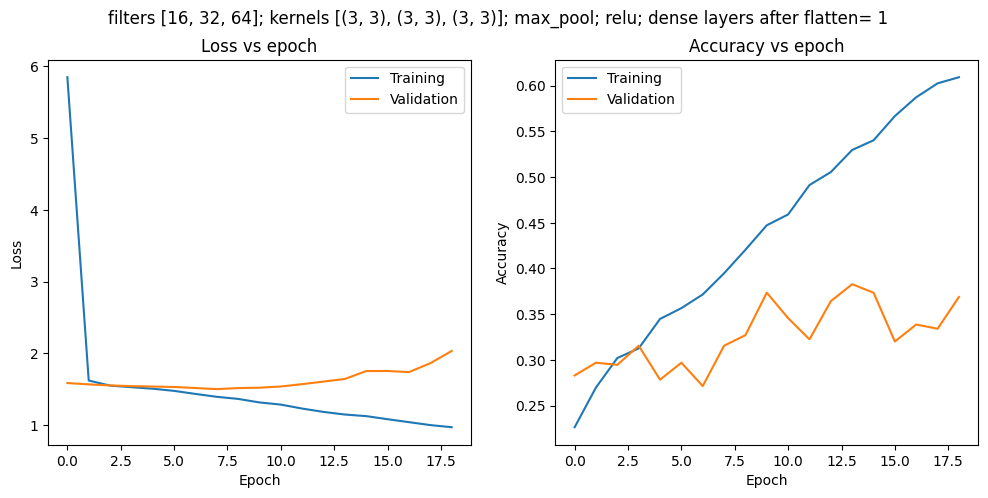

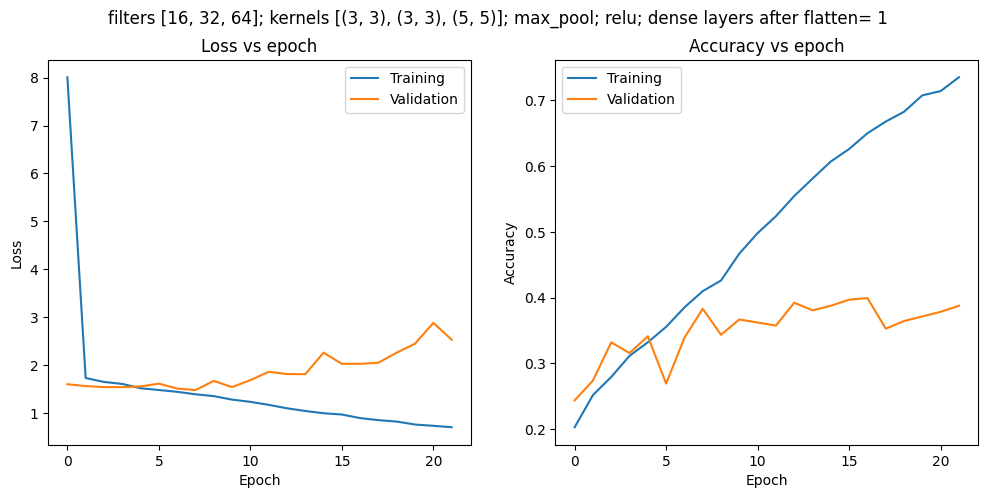

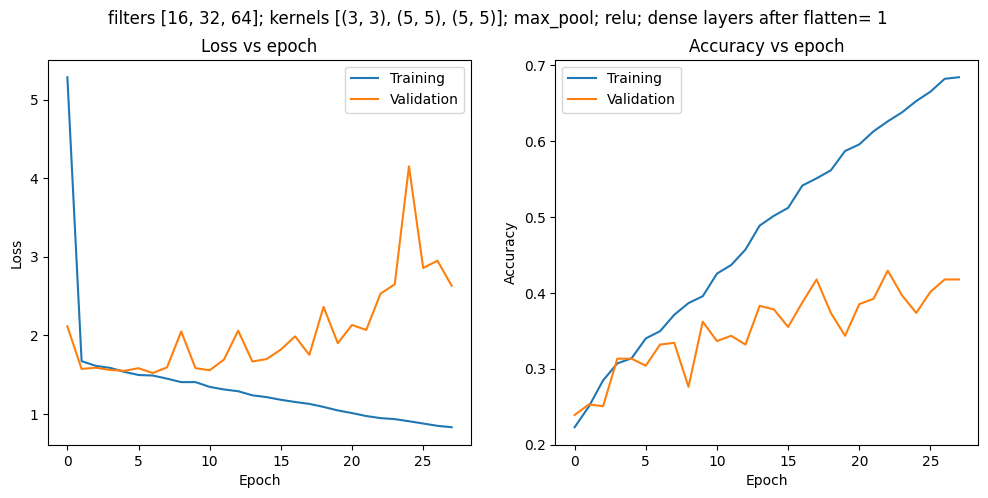

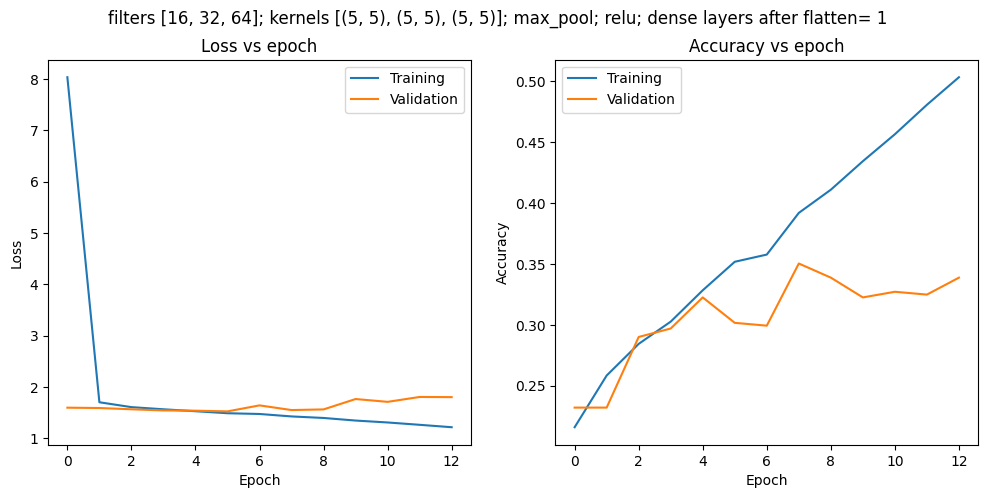

In [5]:
import pandas as pd

result = pd.DataFrame(columns=[
    'Convolution kernel_size',
    'Convolution filters size',
    'Pooling Layers',
    'Activation',
    'FC layer (after Flatten)',
    'Dropout Rate',
    'Validation Loss',
    'Validation Accuracy'
])

convolution_kernels = [
    [(3, 3), (3, 3), (3, 3)],
    [(3, 3), (3, 3), (5, 5)],
    [(3, 3), (5, 5), (5, 5)],
    [(5, 5), (5, 5), (5, 5)],
]
convolution_filters = [16, 32, 64]
activation = 'relu'
dropout_rate = 0.1
num_fc_layers = 1
pool='max'

for kernels in convolution_kernels:
    val_loss, val_acc = train_model(
        drop_rate=dropout_rate,
        conv_kernels=kernels,
        conv_filters=convolution_filters,
        activation=activation,
        pool=pool,
        num_fc_layers=num_fc_layers,
        train_dataset=train_dataset,
        val_dataset=val_dataset
    )

    result.loc[len(result.index)] = [
        kernels,
        convolution_filters,
        pool,
        activation,
        num_fc_layers,
        dropout_rate,
        val_loss,
        val_acc 

    ]

In [6]:
result

,Convolution kernel_size,Convolution filters size,Pooling Layers,Activation,FC layer (after Flatten),Dropout Rate,Validation Loss,Validation Accuracy
0,"[(3, 3), (3, 3), (3, 3)]","[16, 32, 64]",max,relu,1,0.1,1.645490,0.382831
1,"[(3, 3), (3, 3), (5, 5)]","[16, 32, 64]",max,relu,1,0.1,2.023632,0.399072
2,"[(3, 3), (5, 5), (5, 5)]","[16, 32, 64]",max,relu,1,0.1,2.529379,0.429234
3,"[(5, 5), (5, 5), (5, 5)]","[16, 32, 64]",max,relu,1,0.1,1.548485,0.350348


In [7]:
best_conv_kernel = result.sort_values(
    by=['Validation Accuracy', 'Validation Loss'],
    ascending=[False, True]
    )['Convolution kernel_size'].iloc[0]

best_conv_kernel

[(3, 3), (5, 5), (5, 5)]